In [4]:
import torch
from torch import nn
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [111]:
batch_size = 128
dl = torch.utils.data.DataLoader(
    datasets.FashionMNIST('.', train=True, transform=transforms.ToTensor(), download=True),
batch_size=batch_size)

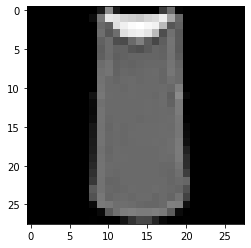

In [119]:
plt.imshow(1 - next(iter(dl))[0][2].view(28, 28).numpy(), cmap='Greys')

In [169]:
def middle_size(size_in, size_out):
    """
    Make a funnel with regard to the number of weights.
    """
    return (size_in - size_out) // 2 + size_out

class VAE(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        
        self.latent_size = latent_size 
        size = middle_size(784, self.latent_size)
        
        # Encode into gaussian paramaters. First part of vector is mu and second part log variance
        self.encoder = nn.Sequential(
            nn.Linear(784, size),
            nn.ReLU(),
            nn.Linear(size, size),
            nn.ReLU(),
            nn.Linear(size, latent_size * 2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, size),
            nn.ReLU(),
            nn.Linear(size, size),
            nn.ReLU(),
            nn.Linear(size, 784),
            nn.Sigmoid()
        )
        
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)  # unit gaussian
        z = mu + eps * std 
        return z

    def forward(self, x):
        z_theta = self.encoder(x)
        mu = z_theta[:, :self.latent_size]
        log_var = z_theta[:, self.latent_size:]
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

# CNN

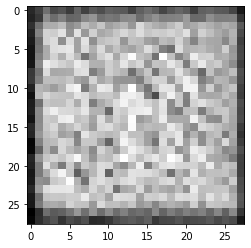

In [171]:
    
class UnFlatten(nn.Module):
    def forward(self, x):
        # Note -1 dimension is inferred.
        return x.view(x.shape[0], -1, 1, 1)
    
    
class CNNVAE(VAE):
    # TODO: find good architecture. 
    def __init__(self, latent_size=400):
        super().__init__(latent_size)
       
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Flatten()
        )
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(self.latent_size, 32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1),
            nn.Sigmoid()
        )

m = CNNVAE()
plt.imshow(m(next(iter(dl))[0])[0][0].view(28, 28).data.numpy(), cmap='Greys')

In [172]:
def loss_function(reconstruction_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(reconstruction_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp())

    return BCE + KLD

In [177]:
latent_size = 250
m = VAE(latent_size)
m.cuda()

def train(epoch, m, device, optimizer):
    m.train()
    train_loss = 0
    for batch_idx, (x, _) in enumerate(dl):
        x = x.to(device).view(-1, 784)
        
        optim.zero_grad()
        recon_batch, mu, logvar = m(x)
        loss = loss_function(recon_batch, x, mu, logvar)
        loss.backward()
        
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 150 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(dl.dataset),
                100. * batch_idx / len(dl),
                loss.item() / len(x)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(dl.dataset)))


optim = torch.optim.Adam(m.parameters(), 1e-3)

for epoch in range(1, 11):
    train(epoch, m, 'cuda', optim)

Train Epoch: 1 [0/60000 (0%)]	Loss: 545.216492
Train Epoch: 1 [19200/60000 (32%)]	Loss: 304.467712
Train Epoch: 1 [38400/60000 (64%)]	Loss: 282.475281
Train Epoch: 1 [57600/60000 (96%)]	Loss: 270.869110
====> Epoch: 1 Average loss: 302.0279
Train Epoch: 2 [0/60000 (0%)]	Loss: 268.287903
Train Epoch: 2 [19200/60000 (32%)]	Loss: 273.701294
Train Epoch: 2 [38400/60000 (64%)]	Loss: 257.615631
Train Epoch: 2 [57600/60000 (96%)]	Loss: 255.759094
====> Epoch: 2 Average loss: 262.8937
Train Epoch: 3 [0/60000 (0%)]	Loss: 252.945618
Train Epoch: 3 [19200/60000 (32%)]	Loss: 264.578156
Train Epoch: 3 [38400/60000 (64%)]	Loss: 250.188477
Train Epoch: 3 [57600/60000 (96%)]	Loss: 252.424652
====> Epoch: 3 Average loss: 253.8822
Train Epoch: 4 [0/60000 (0%)]	Loss: 247.508987
Train Epoch: 4 [19200/60000 (32%)]	Loss: 260.838867
Train Epoch: 4 [38400/60000 (64%)]	Loss: 247.394196
Train Epoch: 4 [57600/60000 (96%)]	Loss: 248.601410
====> Epoch: 4 Average loss: 250.5403
Train Epoch: 5 [0/60000 (0%)]	Loss: 

In [180]:
with torch.no_grad():
    # take 5 samples
    sample = torch.randn(5, latent_size).to('cuda')
    sample = m.decoder(sample).cpu().view(-1, 28, 28)

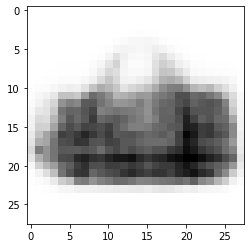

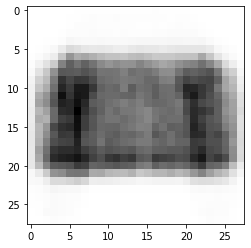

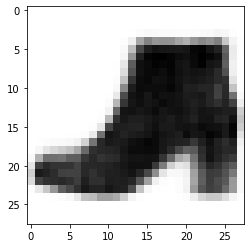

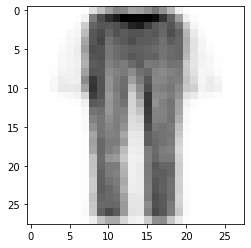

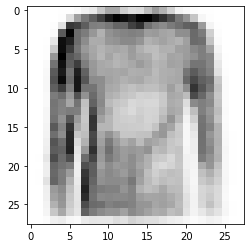

In [181]:
for i in range(sample.shape[0]):
    plt.imshow(sample[i].view(28, 28), cmap='Greys')
    plt.show()

In [262]:
class PlanarFlow(nn.Module):
    def __init__(self, size=1, init_sigma=0.01):
        super().__init__()
        self.u = nn.Parameter(torch.randn(size, ).normal_(0, 0.01))
        self.w = nn.Parameter(torch.randn(size, ).normal_(0, 0.01))
        self.b = nn.Parameter(torch.zeros(size, 1))
    
    @property
    def normalized_u(self):
        """
        Needed for invertibility condition.
        
        See Appendix A.1
        Rezende et al. Variational Inference with Normalizing Flows
        https://arxiv.org/pdf/1505.05770.pdf
        """
        def m(x):
            return -1 + torch.log(1 + torch.exp(x))
        wtu = self.w @ self.u.t()
        return self.u + (m(wtu) - wtu) * self.w / (self.w @ self.w.t())
    
    def psi(self, z):
        """
        ψ(z) =h′(w^tz+b)w
        
        See eq(11)
        Rezende et al. Variational Inference with Normalizing Flows
        https://arxiv.org/pdf/1505.05770.pdf
        """
        return (self.h_prime(z @ self.w.t() + self.b).t() @ self.w.t())
    
    def h(self, x):
        return torch.tanh(x)
        
    def h_prime(self, z):
        return 1 - torch.tanh(z)**2
        
    def forward(self, z):
        if isinstance(z, tuple):
            z, accumulating_log_abs_det = z
        else:
            z, accumulating_log_abs_det = z, 0
        
        psi = self.psi(z)
        u = self.normalized_u
        print(psi.shape, u.shape)
        # determinant of jacobian
        det = (1 + psi @ u.t()).unsqueeze(1)
        
        # log |det Jac|
        log_abs_det = torch.log(torch.abs(det) + 1e-6)
        
        fz = z + u + self.h((z @ self.w.t()).unsqueeze(1) + self.b)
        print(fz.shape)
        
        return fz, log_abs_det + accumulating_log_abs_det

class Planar(nn.Module):
    """
    PyTorch implementation of planar flows as presented in "Variational Inference with Normalizing Flows"
    by Danilo Jimenez Rezende, Shakir Mohamed. Model assumes amortized flow parameters.
    """

    def __init__(self):

        super(Planar, self).__init__()

        self.h = nn.Tanh()
        self.softplus = nn.Softplus()

    def der_h(self, x):
        """ Derivative of tanh """

        return 1 - self.h(x) ** 2

    def forward(self, zk, u, w, b):
        """
        Forward pass. Assumes amortized u, w and b. Conditions on diagonals of u and w for invertibility
        will be be satisfied inside this function. Computes the following transformation:
        z' = z + u h( w^T z + b)
        or actually
        z'^T = z^T + h(z^T w + b)u^T
        Assumes the following input shapes:
        shape u = (batch_size, z_size, 1)
        shape w = (batch_size, 1, z_size)
        shape b = (batch_size, 1, 1)
        shape z = (batch_size, z_size).
        """

        zk = zk.unsqueeze(2)

        # reparameterize u such that the flow becomes invertible (see appendix paper)
        uw = torch.bmm(w, u)
        m_uw = -1. + self.softplus(uw)
        w_norm_sq = torch.sum(w ** 2, dim=2, keepdim=True)
        u_hat = u + ((m_uw - uw) * w.transpose(2, 1) / w_norm_sq)

        # compute flow with u_hat
        wzb = torch.bmm(w, zk) + b
        z = zk + u_hat * self.h(wzb)
        z = z.squeeze(2)

        # compute logdetJ
        psi = w * self.der_h(wzb)
        log_det_jacobian = torch.log(torch.abs(1 + torch.bmm(psi, u_hat)))
        log_det_jacobian = log_det_jacobian.squeeze(2).squeeze(1)

        return z, log_det_jacobian 

class FlowVAE(VAE):
    def __init__(self, latent_size, n_flows=20):
        super().__init__(latent_size)
                
        self.flow = nn.Sequential(*[
            Planar(latent_size) for _ in range(n_flows)
        ])   
            
    def forward(self, x):
        z_theta = self.encoder(x)
        mu0 = z_theta[:, :self.latent_size]
        log_var0 = z_theta[:, self.latent_size:]
        z0 = self.reparameterize(mu0, log_var0)
        zk, accumulating_log_abs_det = self.flow(z0)
        self.decoder(zk)
        
        return z0, zk, self.decoder(zk), accumulating_log_abs_det, mu0, log_var0

In [263]:
def log_normal_standard(x, average=False, reduce=True, dim=None):
    log_norm = -0.5 * x * x

    if reduce:
        if average:
            return torch.mean(log_norm, dim)
        else:
            return torch.sum(log_norm, dim)
    else:
        return log_norm
    
def log_normal_diag(x, mean, log_var, average=False, reduce=True, dim=None):
    log_norm = -0.5 * (log_var + (x - mean) * (x - mean) * log_var.exp().reciprocal())
    if reduce:
        if average:
            return torch.mean(log_norm, dim)
        else:
            return torch.sum(log_norm, dim)
    else:
        return log_norm

    
def det_loss(reconstruction_x, x, mu, log_var, z_0, z_k, ldj, beta=1.):
    """
    :param z_mu: mean of z_0
    :param z_var: variance of z_0
    :param z_0: first stochastic latent variable
    :param z_k: last stochastic latent variable
    :param ldj: log det jacobian
    """

    reconstruction_function = nn.BCELoss(reduction='sum')

    batch_size = x.size(0)

    # - N E_q0 [ ln p(x|z_k) ]
    likelihood = reconstruction_function(reconstruction_x, x)

    # ln p(z_k)  (not averaged)
    log_p_zk = log_normal_standard(z_k, dim=1)
    # ln q(z_0)  (not averaged)
    log_q_z0 = log_normal_diag(z_0, mean=mu, log_var=log_var, dim=1)
    # N E_q0[ ln q(z_0) - ln p(z_k) ]
    summed_logs = torch.sum(log_q_z0 - log_p_zk)

    # sum over batches
    summed_ldj = torch.sum(ldj)

    # ldj = N E_q_z0[\sum_k log |det dz_k/dz_k-1| ]
    kl = (summed_logs - summed_ldj)
    loss = likelihood + beta * kl

    loss = loss / float(batch_size)

    return loss

In [264]:
latent_size = 250
m = FlowVAE(latent_size)
m.cuda()

def train(epoch, m, device, optimizer):
    m.train()
    train_loss = 0
    for batch_idx, (x, _) in enumerate(dl):
        x = x.to(device).view(-1, 784)
        
        optim.zero_grad()
        z0, zk, reconstruction_x, accumulating_log_abs_det, mu0, log_var0 = m(x)
    
        loss = det_loss(x=x, 
                        reconstruction_x=reconstruction_x, 
                        mu=mu0,
                        log_var=log_var0,
                        ldj=accumulating_log_abs_det,
                        z_0=z0,
                        z_k=zk
                        )
        
        recon_batch, mu, logvar = m(x)
        loss = loss_function(recon_batch, x, mu, logvar)
        loss.backward()
        
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 150 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(dl.dataset),
                100. * batch_idx / len(dl),
                loss.item() / len(x)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(dl.dataset)))


optim = torch.optim.Adam(m.parameters(), 1e-3)

for epoch in range(1, 11):
    train(epoch, m, 'cuda', optim)

torch.Size([128]) torch.Size([250])


RuntimeError: invalid argument 2: sizes do not match at /opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/THC/generic/THCTensorMathBlas.cu:20